The Network structure consists of three layers:
1. Input Layer(Flatten Layer):
- The grayscale images of 28*28 pixels
- Flattens the 2D images into 1D vectors of length 784
- This step doesn't involve any parameter so far
2. Hidden Layer:
- Contain 1000 neurons
- Use Rectified Linear Unit for the activation function
- This layer contains numerous parameters (784×1000 weights + 1000 bias terms), giving the network sufficient capacity to learn data features
3. Output Layer:
- Contains 10 neurons, corresponding to the ten digit classes 0-9
- Uses the Softmax activation function to convert outputs into a probability distribution



In [ ]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from backpack import backpack, extend
from backpack.extensions import BatchGrad
import torch.nn.functional as F

# SimpleModel:
# A basic fully connected neural network for classifying MNIST images.
class SimpleModel(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=1000, output_dim=10):
        super(SimpleModel, self).__init__()
        # Flatten layer to convert 2D image input into a 1D vector.
        self.flatten = nn.Flatten()
        # First fully connected layer mapping from input dimension to hidden dimension.
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # ReLU activation function introduces non-linearity after the first layer.
        self.relu = nn.ReLU()
        # Second fully connected layer mapping from hidden dimension to output dimension.
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Flatten the input image.
        x = self.flatten(x)
        # Apply the first layer and its activation.
        x = self.relu(self.fc1(x))
        # Compute final outputs (logits for classification).
        x = self.fc2(x)
        return x

# PCASimpleModel:
# A neural network model that applies PCA-based dimensionality reduction before classification.
class PCASimpleModel(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=1000, output_dim=10):
        super(PCASimpleModel, self).__init__()
        # Flatten layer to convert image input into a vector.
        self.flatten = nn.Flatten()
        # First fully connected layer (applied after PCA transformation).
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # ReLU activation function.
        self.relu = nn.ReLU()
        # Second fully connected layer for output logits.
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def set_pca_components(self, components):
        """
        Register the pre-computed PCA components as a non-trainable buffer.
        This allows the PCA transformation to be applied during the forward pass without affecting gradient updates.
        """
        # Convert components to a FloatTensor.
        components_tensor = torch.FloatTensor(components)
        # Ensure components are on the same device as the model parameters.
        device = next(self.parameters()).device 
        components_tensor = components_tensor.to(device)
        # Register the tensor as a buffer so that it gets moved with the model (but is not updated during training).
        self.register_buffer('pca_components', components_tensor)
        
    def forward(self, x):
        # Flatten the input image.
        x = self.flatten(x)
        # If PCA components are set, apply PCA transformation via matrix multiplication.
        if hasattr(self, 'pca_components') and self.pca_components is not None:
            x = torch.matmul(x, self.pca_components)
        # Pass the PCA-transformed input through the first linear layer with ReLU activation.
        x = self.relu(self.fc1(x))
        # Compute the output logits through the second linear layer.
        x = self.fc2(x)
        return x


Learning Rate Scheduler

In [ ]:
def get_lr_scheduler(optimizer, epochs):
    """
    Returns a learning rate scheduler that adjusts the learning rate during training.
    
    For the first 10 epochs, the learning rate decays linearly from 0.1 to 0.052; thereafter, it remains constant at 0.052.
    
    Parameters:
    - optimizer: The optimizer whose learning rate will be scheduled.
    - epochs: The total number of epochs (not directly used here, but available for potential modifications).
    
    Returns:
    - A LambdaLR scheduler object that applies the defined learning rate schedule.
    """
    def lr_lambda(epoch):
        if epoch < 10:
            # Linear decay between epoch 0 and 10.
            return 0.1 - (0.1 - 0.052) * (epoch / 10)
        else:
            # Constant learning rate after epoch 10.
            return 0.052
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

MNIST Training

In [ ]:
from utils import process_grad_batch, get_sigma
import time

def train_with_dp(model, train_loader, epochs, learning_rate, epsilon, delta, clip_norm=1.0):
    """
    Train a model with differential privacy (DP) techniques integrated.
    
    This function modifies the conventional training loop by applying gradient clipping,
    computing per-batch gradients using Backpack extensions, and adding Gaussian noise to enforce differential privacy.
    
    Parameters:
    - model: The neural network model to be trained.
    - train_loader: DataLoader for the training dataset.
    - epochs: Number of training epochs.
    - learning_rate: Base learning rate for the optimizer.
    - epsilon: Total privacy budget for differential privacy.
    - delta: Delta parameter for differential privacy.
    - clip_norm: Maximum allowed norm for gradients (for gradient clipping).
    
    Returns:
    - A tuple containing:
      - The trained model.
      - A list of training accuracies (per epoch).
      - A list of training times (per epoch).
      - The total training time.
    """
    batch_size = train_loader.batch_size
    n_samples = len(train_loader.dataset)
    sample_probability = batch_size / n_samples  # Compute the probability of selecting a sample in each batch.
    steps = len(train_loader)
    total_steps = epochs * steps  # Total number of training steps.
    
    # Calculate noise scale (sigma) based on DP parameters and the sampling probability.
    sigma, epsilon = get_sigma(sample_probability, total_steps, epsilon, delta)
    
    # Use CrossEntropyLoss with 'sum' reduction for proper gradient scaling.
    criterion = extend(nn.CrossEntropyLoss(reduction='sum'))
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    # Initialize the learning rate scheduler.
    scheduler = get_lr_scheduler(optimizer, epochs)
    
    device = next(model.parameters()).device
    model.train()
    
    train_accuracies = []
    train_times = []
    start_time = time.time()
    
    for epoch in range(epochs):
        epoch_start = time.time()
        correct = 0
        train_loss = 0
        total = 0
        
        for inputs, targets in train_loader:
            # Transfer inputs and targets to the device.
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()  # Clear previous gradients.
            
            outputs = model(inputs)  # Forward propagation.
            loss = criterion(outputs, targets)  # Compute loss.
            
            # Use Backpack to capture per-sample gradients for DP.
            with backpack(BatchGrad()):
                loss.backward()  # Backward propagation.
                
                # Apply gradient clipping to limit the gradient norms.
                process_grad_batch(list(model.parameters()), clip_norm)
                
                # Add Gaussian noise to each gradient for differential privacy.
                for p in model.parameters():
                    if p.requires_grad and p.grad is not None:
                        noise = torch.normal(
                            mean=0,
                            std=sigma * clip_norm / batch_size,
                            size=p.grad.shape,
                            device=p.grad.device
                        )
                        p.grad += noise
            
            optimizer.step()  # Update model parameters.
            
            # Update running loss and accuracy.
            train_loss += loss.item() / inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        
        epoch_time = time.time() - epoch_start  # Duration of the epoch.
        train_times.append(epoch_time)
        accuracy = 100 * correct / total
        train_accuracies.append(accuracy)
        
        scheduler.step()  # Adjust the learning rate as per schedule.
        
        print(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss/total:.4f}, ' +
              f'Accuracy: {accuracy:.2f}%, Time: {epoch_time:.2f}s')
        
    total_time = time.time() - start_time
    print(f"Total training time: {total_time:.2f} seconds")
    return model, train_accuracies, train_times, total_time

def train_without_dp(model, train_loader, epochs, learning_rate):
    """
    Train a model using the standard training loop without applying differential privacy.
    
    Parameters:
    - model: The neural network model to be trained.
    - train_loader: DataLoader for the training dataset.
    - epochs: Number of training epochs.
    - learning_rate: Learning rate for the optimizer.
    
    Returns:
    - A tuple containing:
      - The trained model.
      - A list of training accuracies (per epoch).
      - A list of training times (per epoch).
      - The total training time.
    """
    # Standard CrossEntropyLoss for classification tasks.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    device = next(model.parameters()).device
    model.train()
    
    train_accuracies = []
    train_times = []
    start_time = time.time()
    
    for epoch in range(epochs):
        epoch_start = time.time()
        correct = 0
        train_loss = 0
        total = 0
        
        for inputs, targets in train_loader:
            # Move inputs and targets to the designated device.
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()  # Reset gradients from previous iteration.
            
            outputs = model(inputs)  # Forward pass.
            loss = criterion(outputs, targets)  # Compute the loss.
            loss.backward()  # Backward pass for gradient calculation.
            optimizer.step()  # Update model weights.
            
            # Accumulate loss and compute correct predictions.
            train_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        
        epoch_time = time.time() - epoch_start
        train_times.append(epoch_time)
        accuracy = 100 * correct / total
        train_accuracies.append(accuracy)
        
        print(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss/total:.4f}, ' +
              f'Accuracy: {accuracy:.2f}%, Time: {epoch_time:.2f}s')
    
    total_time = time.time() - start_time
    print(f"Total training time: {total_time:.2f} seconds")
    
    return model, train_accuracies, train_times, total_time


Test Model

In [ ]:
def test_model(model, test_loader):
    """
    Evaluate the model on the test dataset.
    
    This function calculates the average loss and overall accuracy on the test set.
    
    Parameters:
    - model: The neural network model to be evaluated.
    - test_loader: DataLoader for the test dataset.
    
    Returns:
    - The test accuracy expressed as a percentage.
    """
    model.eval()  # Set the model to evaluation mode.
    test_loss = 0 
    correct = 0
    
    device = next(model.parameters()).device
    # Define loss function with 'sum' reduction for aggregating test loss.
    criterion = nn.CrossEntropyLoss(reduction='sum')
    
    # Disable gradient computation for testing.
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)  # Forward pass.
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    # Calculate average loss per sample.
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)')
    
    return accuracy

Load MNIST, MNIST is a classic machine learning dataset containing a large number of handwritten digit imagmes(from 0 to 9), with each image size at 28*28 pixels.


In [15]:
from torchvision import transforms
from torchvision import datasets

def main():
    
    """Paper Parameters"""
    batch_size = 600 
    lr= 0.1
    epochs = 100
    epsilon = 2
    delta = 1e-5
    clip_norm = 4
    
    """ Load MNIST Dataset """
    trainform = transforms.Compose([
        transforms.ToTensor(),
    ])

    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=trainform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=trainform)

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")    
    model = SimpleModel().to(device)
    model = extend(model)
    
    train_model = train_with_dp(model, train_loader, epochs, lr, epsilon, delta, clip_norm)
    
    torch.save(train_model.state_dict(), 'mnist_dp_model.pth')
    
    test_model(train_model, test_loader)
    
if __name__ == '__main__':
    main()

/home/tommy/miniconda3/envs/DataPrivacy/lib/python3.12/site-packages/backpack/extensions/backprop_extension.py:107: UserWarning: Extension saving to grad_batch does not have an extension for Module <class '__main__.SimpleModel'> although the module has parameters
  warnings.warn(


Epoch 1/100, Loss: 0.0036721329786512593, Accuracy: 0.3902
Epoch 2/100, Loss: 0.0032837869974772123, Accuracy: 0.6705666666666666
Epoch 3/100, Loss: 0.002887451504177518, Accuracy: 0.7024
Epoch 4/100, Loss: 0.0025174152679443367, Accuracy: 0.7141833333333333
Epoch 5/100, Loss: 0.0022092158593071828, Accuracy: 0.7258333333333333
Epoch 6/100, Loss: 0.00196254738023546, Accuracy: 0.74585
Epoch 7/100, Loss: 0.00177384029812283, Accuracy: 0.7628
Epoch 8/100, Loss: 0.001626725626627604, Accuracy: 0.7782166666666667
Epoch 9/100, Loss: 0.0015112150115966793, Accuracy: 0.79005
Epoch 10/100, Loss: 0.001421371757507324, Accuracy: 0.79835
Epoch 11/100, Loss: 0.0013488293762207036, Accuracy: 0.8069666666666667
Epoch 12/100, Loss: 0.0012893528467814136, Accuracy: 0.8123
Epoch 13/100, Loss: 0.0012378559256659618, Accuracy: 0.8169
Epoch 14/100, Loss: 0.001190820870293511, Accuracy: 0.8221333333333334
Epoch 15/100, Loss: 0.0011496577996147998, Accuracy: 0.8259666666666666
Epoch 16/100, Loss: 0.00111197

MNIST Main

Using device: cuda
Computing differentially private PCA...
PCA completed with 60 components


==== Experiment 1: Without DP, Without PCA ====
Epoch 1/100, Loss: 1.0985, Accuracy: 77.93%, Time: 1.23s
Epoch 2/100, Loss: 0.4526, Accuracy: 88.28%, Time: 1.20s
Epoch 3/100, Loss: 0.3691, Accuracy: 89.90%, Time: 1.21s
Epoch 4/100, Loss: 0.3322, Accuracy: 90.75%, Time: 1.18s
Epoch 5/100, Loss: 0.3081, Accuracy: 91.29%, Time: 1.30s
Epoch 6/100, Loss: 0.2897, Accuracy: 91.83%, Time: 1.20s
Epoch 7/100, Loss: 0.2741, Accuracy: 92.28%, Time: 1.20s
Epoch 8/100, Loss: 0.2606, Accuracy: 92.64%, Time: 1.18s
Epoch 9/100, Loss: 0.2485, Accuracy: 93.05%, Time: 1.20s
Epoch 10/100, Loss: 0.2375, Accuracy: 93.40%, Time: 1.20s
Epoch 11/100, Loss: 0.2273, Accuracy: 93.69%, Time: 1.20s
Epoch 12/100, Loss: 0.2181, Accuracy: 93.95%, Time: 1.20s
Epoch 13/100, Loss: 0.2096, Accuracy: 94.19%, Time: 1.30s
Epoch 14/100, Loss: 0.2015, Accuracy: 94.40%, Time: 1.20s
Epoch 15/100, Loss: 0.1941, Accuracy: 94.63%, Time: 1.1

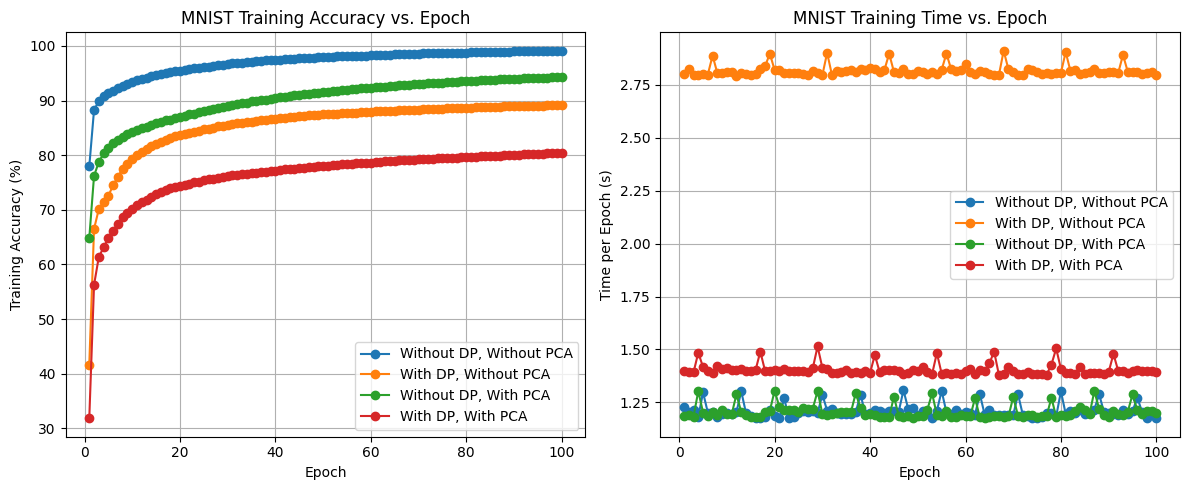

Models saved. Experiment completed!


In [25]:
import matplotlib.pyplot as plt
import time
from utils import differentially_private_pca

def run_comparison_experiment():
    # Set hyperparameters for training and DP/PCA configurations
    batch_size = 600      # Number of samples per batch
    lr = 0.1              # Learning rate for optimization
    epochs = 100          # Total number of training epochs
    epsilon = 2           # Privacy budget for differential privacy (DP)
    delta = 1e-5          # Delta parameter for DP
    clip_norm = 4         # Gradient clipping norm for DP
    pca_dim = 60          # Target dimension for PCA
    pca_epsilon = 0.5     # Privacy budget allocated for the DP PCA step
    
    # Determine the computation device (use GPU if available, otherwise CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Load the MNIST dataset with basic transformation (convert images to tensor)
    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    
    # Create data loaders for training and testing
    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset, batch_size=batch_size, shuffle=False)
    
    # Compute differentially private PCA components using the entire training set
    print("Computing differentially private PCA...")
    all_data, _ = next(iter(torch.utils.data.DataLoader(
        dataset=train_dataset, batch_size=len(train_dataset), shuffle=True)))
    
    pca_components = differentially_private_pca(
        all_data, n_components=pca_dim, epsilon=pca_epsilon, delta=delta)
    print(f"PCA completed with {pca_dim} components")
    
    # Initialize a dictionary to store results for each experimental configuration
    results = {
        'without_dp_without_pca': {},
        'with_dp_without_pca': {},
        'without_dp_with_pca': {},
        'with_dp_with_pca': {}
    }
    
    # Experiment 1: No differential privacy (DP) and no PCA transformation
    print("\n\n==== Experiment 1: Without DP, Without PCA ====")
    model1 = SimpleModel(input_dim=784).to(device)
    model1, acc1, times1, total_time1 = train_without_dp(model1, train_loader, epochs, lr)
    test_acc1 = test_model(model1, test_loader)
    
    results['without_dp_without_pca'] = {
        'train_accuracies': acc1,
        'train_times': times1,
        'total_time': total_time1,
        'test_accuracy': test_acc1
    }
    
    # Experiment 2: Apply differential privacy (DP) but without PCA transformation
    print("\n\n==== Experiment 2: With DP, Without PCA ====")
    model2 = SimpleModel(input_dim=784).to(device)
    model2 = extend(model2)  # Extend the model to incorporate DP functionalities (e.g., gradient noise addition)
    model2, acc2, times2, total_time2 = train_with_dp(model2, train_loader, epochs, lr, epsilon, delta, clip_norm)
    test_acc2 = test_model(model2, test_loader)
    
    results['with_dp_without_pca'] = {
        'train_accuracies': acc2,
        'train_times': times2,
        'total_time': total_time2,
        'test_accuracy': test_acc2
    }
    
    # Experiment 3: No DP but use PCA for dimensionality reduction
    print("\n\n==== Experiment 3: Without DP, With PCA ====")
    model3 = PCASimpleModel(input_dim=pca_dim).to(device)
    model3.set_pca_components(pca_components)  # Set the pre-computed PCA components in the model
    model3, acc3, times3, total_time3 = train_without_dp(model3, train_loader, epochs, lr)
    test_acc3 = test_model(model3, test_loader)
    
    results['without_dp_with_pca'] = {
        'train_accuracies': acc3,
        'train_times': times3,
        'total_time': total_time3,
        'test_accuracy': test_acc3
    }
    
    # Experiment 4: Combine differential privacy (DP) with PCA
    print("\n\n==== Experiment 4: With DP, With PCA ====")
    model4 = PCASimpleModel(input_dim=pca_dim).to(device)
    model4 = extend(model4)  # Extend the PCA model to incorporate DP functionalities
    model4.set_pca_components(pca_components)  # Set the PCA components for the model
    # Adjust the privacy budget for training after accounting for PCA
    train_epsilon = epsilon - pca_epsilon
    model4, acc4, times4, total_time4 = train_with_dp(model4, train_loader, epochs, lr, train_epsilon, delta, clip_norm)
    test_acc4 = test_model(model4, test_loader)
    
    results['with_dp_with_pca'] = {
        'train_accuracies': acc4,
        'train_times': times4,
        'total_time': total_time4,
        'test_accuracy': test_acc4
    }
    
    # Print the summary of results from all experiments
    print("\n\n==== Results Summary ====")
    print(f"{'Configuration':<25} {'Test Accuracy':<15} {'Training Time':<15}")
    print("-" * 55)
    print(f"{'Without DP, Without PCA':<25} {test_acc1:.2f}%{'':<10} {total_time1:.2f}s")
    print(f"{'With DP, Without PCA':<25} {test_acc2:.2f}%{'':<10} {total_time2:.2f}s")
    print(f"{'Without DP, With PCA':<25} {test_acc3:.2f}%{'':<10} {total_time3:.2f}s")
    print(f"{'With DP, With PCA':<25} {test_acc4:.2f}%{'':<10} {total_time4:.2f}s")
    
    # Visualize training accuracy and per-epoch training time trends for all experiments
    plt.figure(figsize=(12, 5))
    
    # Plot training accuracies over epochs
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), acc1, 'o-', label='Without DP, Without PCA')
    plt.plot(range(1, epochs+1), acc2, 'o-', label='With DP, Without PCA')
    plt.plot(range(1, epochs+1), acc3, 'o-', label='Without DP, With PCA')
    plt.plot(range(1, epochs+1), acc4, 'o-', label='With DP, With PCA')
    plt.xlabel('Epoch')
    plt.ylabel('Training Accuracy (%)')
    plt.title('MNIST Training Accuracy vs. Epoch')
    plt.legend()
    plt.grid(True)
    
    # Plot training time per epoch
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), times1, 'o-', label='Without DP, Without PCA')
    plt.plot(range(1, epochs+1), times2, 'o-', label='With DP, Without PCA')
    plt.plot(range(1, epochs+1), times3, 'o-', label='Without DP, With PCA')
    plt.plot(range(1, epochs+1), times4, 'o-', label='With DP, With PCA')
    plt.xlabel('Epoch')
    plt.ylabel('Time per Epoch (s)')
    plt.title('MNIST Training Time vs. Epoch')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('MNIST_comparison_results.png')
    plt.show()
    
    # Save the trained models for future use or further analysis
    torch.save(model1.state_dict(), 'model_without_dp_without_pca.pth')
    torch.save(model2.state_dict(), 'model_with_dp_without_pca.pth')
    torch.save(model3.state_dict(), 'model_without_dp_with_pca.pth')
    torch.save(model4.state_dict(), 'model_with_dp_with_pca.pth')
    
    print("Models saved. Experiment completed!")
    return results

if __name__ == '__main__':
    run_comparison_experiment()
